### Analysis and plotting of structural networks from Tractflow output


In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns

### Paths

In [9]:
dataset = "qpn"
current_release = "Jan_2024"
TF_version = "v1.5.0"

# /home/nikhil/projects/Parkinsons/qpn/derivatives/freesurfer/v7.3.2/IDP/ses-01

dataset_dir = f"/home/nikhil/projects/Parkinsons/{dataset}/"
release_dir = f"{dataset_dir}/releases/{current_release}"
tabular_dir = f"{release_dir}/tabular/"
derivatives_dir = f"{release_dir}/derivatives/"
proc_dir = f"{release_dir}/proc/"

# Current nipoppy manifest
manifest_csv = f"{tabular_dir}/manifest.csv"

# demographics
demographics_csv = f"{tabular_dir}/demographics/demographics.csv"

# Tractoflow extractions
tractflow_extract_dir = f"{derivatives_dir}/networks/{TF_version}"


### Load data

#### Demographics for MRI participants

In [3]:
visit = "MRI_v1"

demo_df = pd.read_csv(demographics_csv)
mri_demo_df = demo_df[demo_df["visit"]==visit]
participants = mri_demo_df["participant_id"].unique()
n_participants = len(participants)
print(f"Number of participants: {n_participants}")

print(mri_demo_df["group_at_screening"].value_counts())
PD_group = "PD   (Parkinson's Disease)/Maladie de Parkinson"
HC_group = "Healthy control/Contrôle"

PD_participants = list(mri_demo_df[mri_demo_df["group_at_screening"]==PD_group]["participant_id"].unique())
HC_participants = list(mri_demo_df[mri_demo_df["group_at_screening"]==HC_group]["participant_id"].unique())

print(f"Number of PD participants: {len(PD_participants)}")
print(f"Number of HC participants: {len(HC_participants)}")

mri_demo_df.head()

Number of participants: 286
group_at_screening
PD   (Parkinson's Disease)/Maladie de Parkinson                203
Healthy control/Contrôle                                        67
PPS (Parkinson Plus Syndrome)/PPS (Syndrome Parkinson Plus)     11
Name: count, dtype: int64
Number of PD participants: 203
Number of HC participants: 67


,participant_id,redcap_event_name,group_at_screening,sex,years_education_at_screening,duration_disease_at_screening,diagnosis_determined,assessment,visit_id,age,visit
0,MNI0028,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,M,18,3.5,PD,MRI,v1,60.19,MRI_v1
5,MNI0056,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,M,6,6.5,NaN,MRI,v1,79.24,MRI_v1
9,MNI0058,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,M,11,3.8,PD,MRI,v1,57.43,MRI_v1
13,MNI0068,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,M,12,10.2,PD,MRI,v1,69.30,MRI_v1
16,MNI0079,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,F,20+,6.8,PD,MRI,v1,50.08,MRI_v1


#### TF extractions

In [4]:
# Network regions
atlas = "Schaefer2018"
desc = "1000Parcels7Networks"

network_regions = f"{tractflow_extract_dir}/atlas-{atlas}_desc-{desc}_dseg.tsv"

network_regions_df = pd.read_csv(network_regions, sep="\t")
print(f"network_regions_df.shape: {network_regions_df.shape}")
network_regions_df[["n_regions", "hemi", "network", "network_index"]] = network_regions_df["name"].str.split("_",n=3,expand=True)
network_regions_df.head()

network_regions_df.shape: (1000, 3)


,index,name,color,n_regions,hemi,network,network_index
0,1,7Networks_LH_Vis_1,#780e7f,7Networks,LH,Vis,1
1,2,7Networks_LH_Vis_2,#780e80,7Networks,LH,Vis,2
2,3,7Networks_LH_Vis_3,#780e81,7Networks,LH,Vis,3
3,4,7Networks_LH_Vis_4,#780e82,7Networks,LH,Vis,4
4,5,7Networks_LH_Vis_5,#780e83,7Networks,LH,Vis,5


In [5]:
session = "ses-01"

# participant_id = "sub-PD00020"
PD_network_df_list = []
HC_network_df_list = []
missing_participants = []
for participant_id in PD_participants + HC_participants:
    bids_id = f"sub-{participant_id}"
    participant_extraction_dir = f"{tractflow_extract_dir}/{bids_id}/{session}/dwi/"
    network_tsv = f"{participant_extraction_dir}/{bids_id}_{session}_space-dwi_atlas-{atlas}_desc-{desc}_conmat-count.tsv"

    try:
        network_df = pd.read_csv(network_tsv, sep="\t", index_col = None, header= None)
    except FileNotFoundError:
        missing_participants.append(participant_id)
        print(f"File not found: {network_tsv}")
        continue

    if participant_id in PD_participants:
        PD_network_df_list.append(network_df.values)
    elif participant_id in HC_participants:
        HC_network_df_list.append(network_df.values)
    else:
        print(f"Participant {participant_id} not in PD or HC group")
        

print(f"network list length: HC:{len(HC_network_df_list)}, PD:{len(PD_network_df_list)}")

File not found: /home/nikhil/projects/Parkinsons/qpn//releases/Jan_2024/derivatives//networks/v1.5.0/sub-MNI0028/ses-01/dwi//sub-MNI0028_ses-01_space-dwi_atlas-Schaefer2018_desc-1000Parcels7Networks_conmat-count.tsv
File not found: /home/nikhil/projects/Parkinsons/qpn//releases/Jan_2024/derivatives//networks/v1.5.0/sub-MNI0562/ses-01/dwi//sub-MNI0562_ses-01_space-dwi_atlas-Schaefer2018_desc-1000Parcels7Networks_conmat-count.tsv
File not found: /home/nikhil/projects/Parkinsons/qpn//releases/Jan_2024/derivatives//networks/v1.5.0/sub-MNI0568/ses-01/dwi//sub-MNI0568_ses-01_space-dwi_atlas-Schaefer2018_desc-1000Parcels7Networks_conmat-count.tsv
File not found: /home/nikhil/projects/Parkinsons/qpn//releases/Jan_2024/derivatives//networks/v1.5.0/sub-MNI0590/ses-01/dwi//sub-MNI0590_ses-01_space-dwi_atlas-Schaefer2018_desc-1000Parcels7Networks_conmat-count.tsv
File not found: /home/nikhil/projects/Parkinsons/qpn//releases/Jan_2024/derivatives//networks/v1.5.0/sub-MNI0607/ses-01/dwi//sub-MNI0607

In [7]:
print(f"n missing participants: {len(missing_participants)}")

n missing participants: 17


In [11]:
missing_participants_df = pd.DataFrame(missing_participants, columns=["participant_id"])
missing_participants_df.to_csv(f"{proc_dir}/hpc_job_list_tractoflow_ses-01_resubmit.txt", index=False, header=None)

### Aggregate and thrshold group networks

In [ ]:
threshold_network = "remove_outliers"

threshold_dict = { 
    "100Parcels7Networks" : {
        "binarize": 100,
        "lower_bound": 100,
        "upper_bound": 4000
    },
    "1000Parcels7Networks" : {
        "binarize": 10,
        "lower_bound": 2,
        "upper_bound": 50
    }
}

PD_network_df = np.stack(PD_network_df_list,axis=2).mean(axis=2)
HC_network_df = np.stack(HC_network_df_list,axis=2).mean(axis=2)

# sanity checks
PD_avg_connectivity = PD_network_df.mean()
HC_avg_connectivity = HC_network_df.mean()
print("-"*50)
print(f"PD_avg_connectivity: {PD_avg_connectivity}")
print(f"HC_avg_connectivity: {HC_avg_connectivity}")
print("-"*50)

if threshold_network == "binarize":
    print("Binarizing")
    thrshold = threshold_dict[desc]["binarize"]
    PD_network_df = (PD_network_df > thrshold).astype(int)
    HC_network_df = (HC_network_df > thrshold).astype(int)

elif threshold_network == "remove_outliers":
    print("Removing outliers")
    lower_bound = threshold_dict[desc]["lower_bound"]
    upper_bound = threshold_dict[desc]["upper_bound"]
    PD_network_df[(PD_network_df < lower_bound)] = 0
    PD_network_df[(PD_network_df > upper_bound)] = upper_bound
    HC_network_df[(HC_network_df < lower_bound)] = 0
    HC_network_df[(HC_network_df > upper_bound)] = upper_bound
else:
    print("No thresholding applied")

# sanity checks
PD_avg_connectivity = PD_network_df.mean()
HC_avg_connectivity = HC_network_df.mean()
print("-"*50)
print(f"PD_avg_connectivity: {PD_avg_connectivity}")
print(f"HC_avg_connectivity: {HC_avg_connectivity}")
print("-"*50)
print(f"PD_network_df.shape: {PD_network_df.shape}")
print(f"HC_network_df.shape: {HC_network_df.shape}")

--------------------------------------------------
PD_avg_connectivity: 2.2348319062499997
HC_avg_connectivity: 2.0446683606557374
--------------------------------------------------
Removing outliers
--------------------------------------------------
PD_avg_connectivity: 1.7756015729166665
HC_avg_connectivity: 1.6415315409836064
--------------------------------------------------
PD_network_df.shape: (1000, 1000)
HC_network_df.shape: (1000, 1000)


### Plots

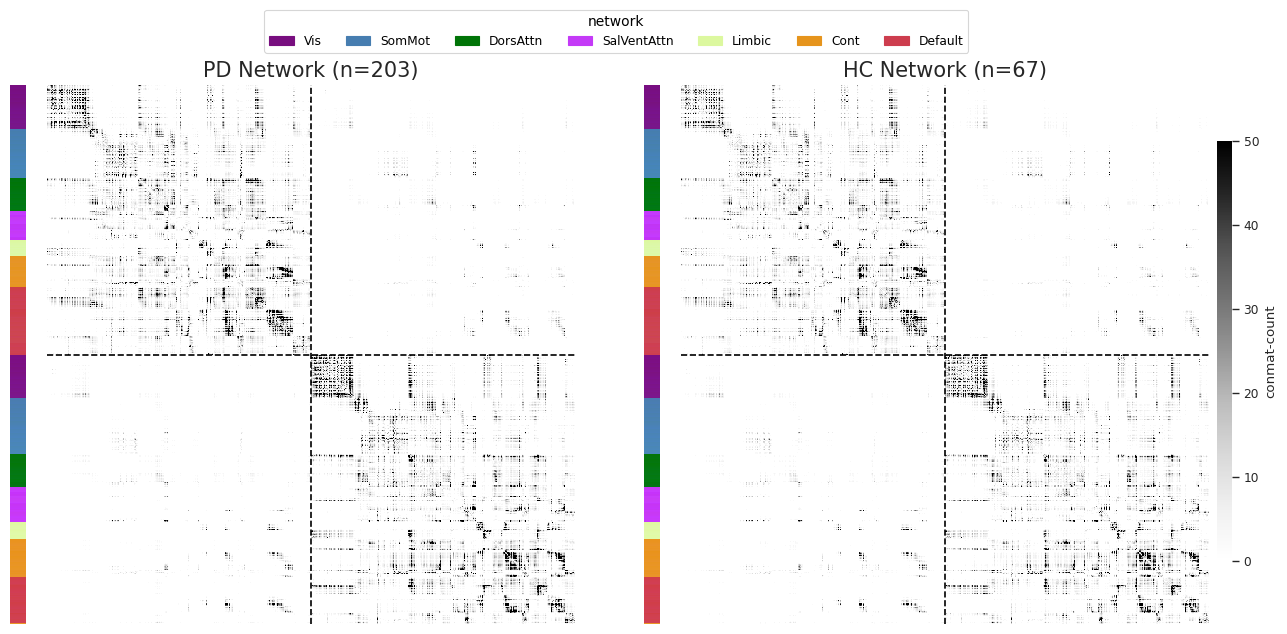

In [ ]:
cmap = "Greys"
row_colors = network_regions_df["color"]

legend_TN = [mpatches.Patch(color=c, label=l) for c,l in network_regions_df[['color','network']].drop_duplicates("network").values]
midline_idx = PD_network_df.shape[0]//2

with sns.axes_style("white"):
    sns.set_context("paper")
    fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(15, 7))
    cbar_ax = fig.add_axes([.905, .2, .01, .6])

    # -------------------------------------------------------------------------------------#
    # PD
    # -------------------------------------------------------------------------------------#
    plot_df = PD_network_df.copy()
    ax = axes[0]
    g = sns.heatmap(plot_df, square=False, xticklabels=False, yticklabels=False, cmap=cmap, ax=ax, cbar=False) #cbar_kws={"shrink": .5}
    g.set_xticklabels(g.get_xticklabels(), rotation=0)
    ax.set_title(f"PD Network (n={len(PD_participants)})",fontsize=15)
    ax.axhline(y=midline_idx, color='k', linestyle='--')
    ax.axvline(x=midline_idx, color='k', linestyle='--')
   
    for i, color in enumerate(row_colors):
        g.add_patch(plt.Rectangle(xy=(-0.07, i), width=0.03, height=1, color=color, lw=0,
                                transform=g.get_yaxis_transform(), clip_on=False))

    # -------------------------------------------------------------------------------------#
    # HC
    # -------------------------------------------------------------------------------------#
    plot_df = HC_network_df.copy()
    ax = axes[1]
    g = sns.heatmap(plot_df, square=False, xticklabels=False, yticklabels=False, cmap=cmap, ax=ax, 
                    cbar_kws= {'label': 'conmat-count'},cbar_ax=cbar_ax) #cbar_kws={"shrink": .5}
    g.set_xticklabels(g.get_xticklabels(), rotation=0)
    ax.set_title(f"HC Network (n={len(HC_participants)})",fontsize=15)
    ax.axhline(y=midline_idx, color='k', linestyle='--')
    ax.axvline(x=midline_idx, color='k', linestyle='--')

    for i, color in enumerate(row_colors):
        g.add_patch(plt.Rectangle(xy=(-0.07, i), width=0.03, height=1, color=color, lw=0,
                                transform=g.get_yaxis_transform(), clip_on=False))
    
l2=g.legend(loc='center left',bbox_to_anchor=(-0.8,1.1),ncol=7, handles=legend_TN,frameon=True) #(1.01,0.9)
l2.set_title(title='network',prop={'size':10})
# plt.tight_layout()